# 1. Get the data

This code is a didactic reinterpretation of chatper 2 from the book _"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"_ by Aurélien Géron.

## Download the data

In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [53]:
from utils.data_loader import load_csv

housing_full = load_csv("housing.csv")

✅ Loaded local file: datasets\housing.csv


## Take a quick look at the data structure

In total, there are 10 attributes.

In [54]:
housing_full.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


-When applying the info() method, we observe that there are a total of 26,460 instances in the dataset, but the "total_bedrooms" column has only 20,433 non-null values, meaning there are 207 missing entries.

-There are 9 numerical variables and one categorical variable (ocean_proximity).

In [55]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [56]:
#missing values
housing_full.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [57]:
housing_full['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Below is a summary of the numerical variables.

In [58]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


A histogram provides a quick overview of the distribution of each numerical attribute, helping to understand how the data is spread and where most values are concentrated.

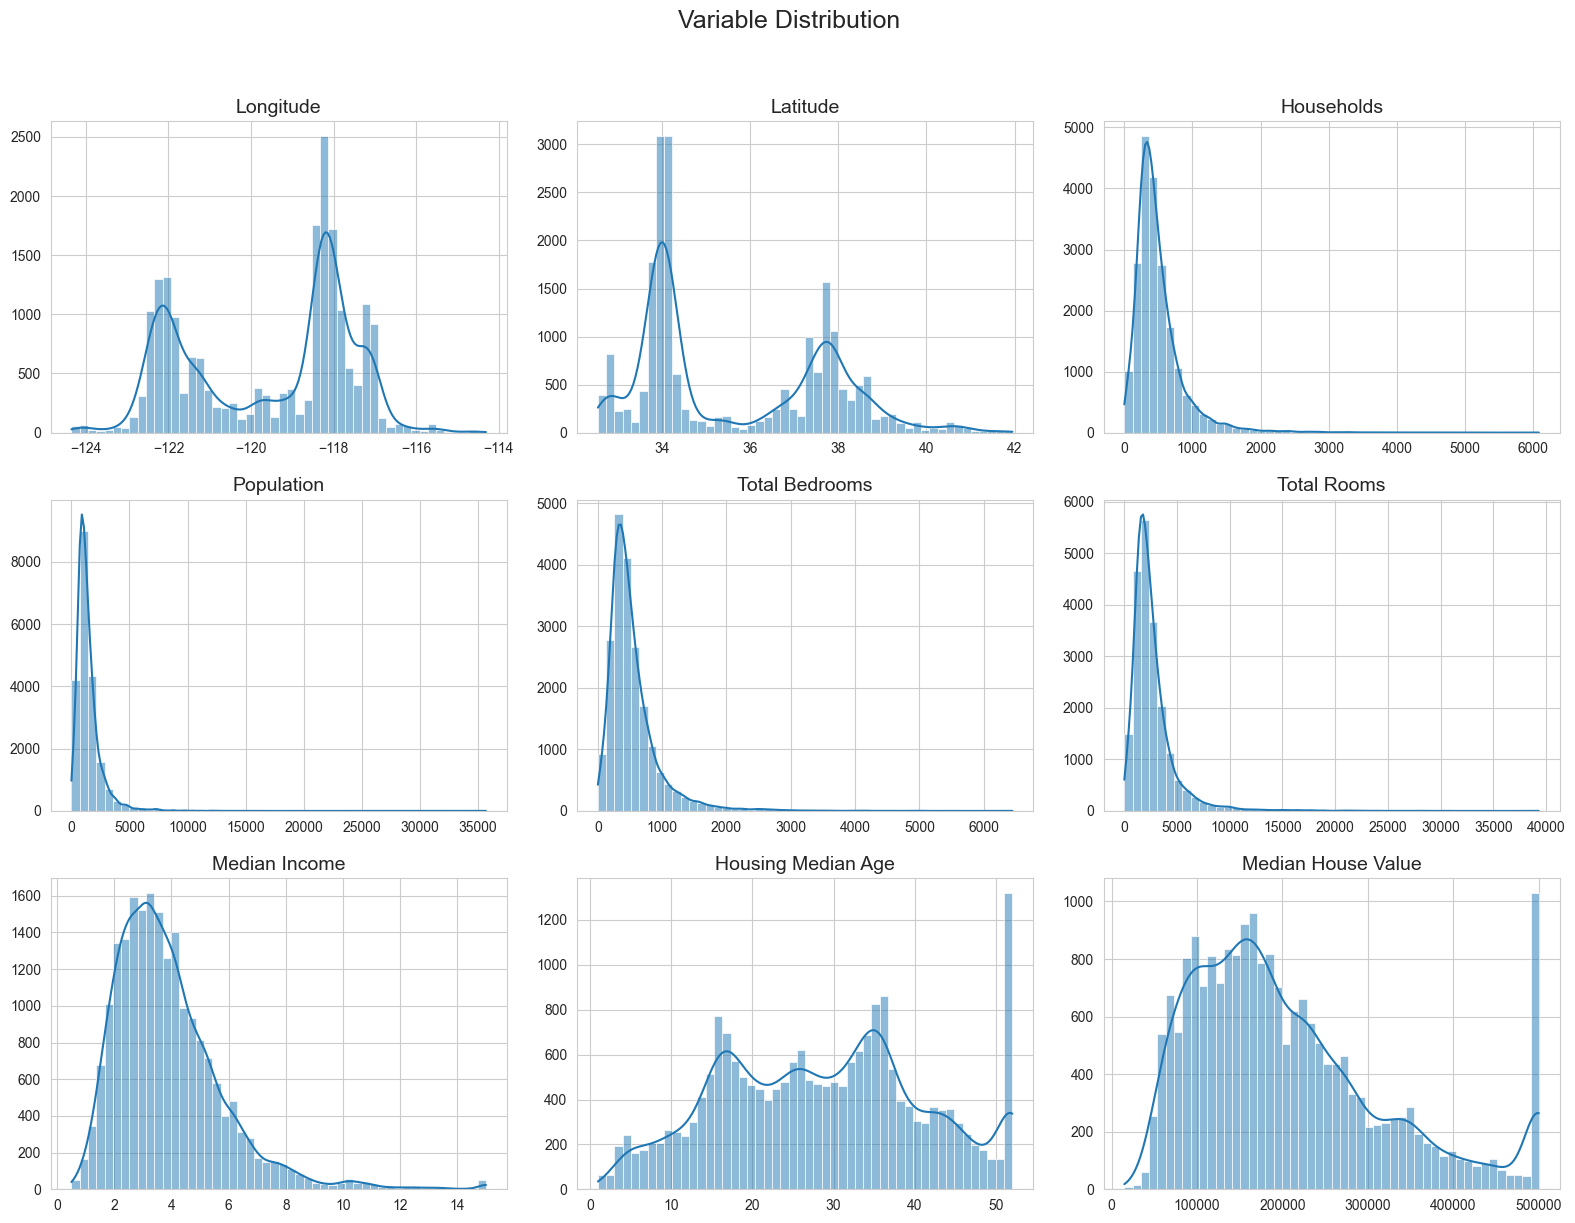

In [59]:
# Estilo global
sns.set_style("whitegrid")
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Lista de columnas a graficar
columns = [
    'longitude', 'latitude', 'households',
    'population', 'total_bedrooms', 'total_rooms',
    'median_income', 'housing_median_age', 'median_house_value'
]

# Crear figura
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle("Variable Distribution", fontsize=18, y=1.02)

# Crear los histogramas
for col, ax in zip(columns, axes.ravel()):
    data = housing_full[col].dropna()  # por si tiene nulos
    sns.histplot(data, ax=ax, bins=50, kde=True)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

**Considerations**
- media_income has been scaled and capped at 15 for higher median incomes, and at 0.5 for lower median incomes.
- housing_median_age was algo capped.
- median_house_value was algo capped. This may be a serious problem. The ML algorithm may prices never go beyond that limit.

**Insights**
- Attributes have very different scales.
- Many histograms are skewed right (they extend much farther to the right of the median than to the left).

## Create a test set

**Assumption**
It is assumed that **median income** is an important variable for predicting housing prices. Therefore, it is useful to ensure that the test set is representative of the different income levels in the dataset. Since median income is a continuous numerical variable, it should first be transformed into categorical intervals.

- According to summary statistics, 90% of the data falls below 6.15
- Only 10% of the data goes beyond 6.0, up to a max of ~15
- Creating fewer, well-populated strata (e.g., 5 bins) helps avoid bias in stratified sampling
- The following bins capture the main distribution while keeping higher incomes grouped

In [60]:
#Basic statistics + percentiles
data = housing_full["median_income"].dropna()
summary = data.describe(percentiles=[.05, .25, .5, .75, .90, .95, .99])
print(summary)

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
5%           1.600570
25%          2.563400
50%          3.534800
75%          4.743250
90%          6.159210
95%          7.300305
99%         10.596540
max         15.000100
Name: median_income, dtype: float64


To ensure the test set is representative of the overall income distribution, we create a new categorical attribute called income_cat. This is done by dividing the median_income variable into five predefined bins:

Bin 1: (0, 1.5] → Very low income

Bin 2: (1.5, 3.0] → Low income

Bin 3: (3.0, 4.5] → Medium income

Bin 4: (4.5, 6.0] → High income

Bin 5: (6.0, ∞) → Very high income

This stratification helps preserve the income distribution when splitting the dataset into training and test sets, avoiding bias that might result from random sampling.

In [61]:
income_bins = [0., 1.5, 3.0, 4.5, 6., np.inf]
income_labels = [1, 2, 3, 4, 5]

housing_full["income_cat"] = pd.cut(
    housing_full["median_income"],
    bins=income_bins,
    labels=income_labels
)

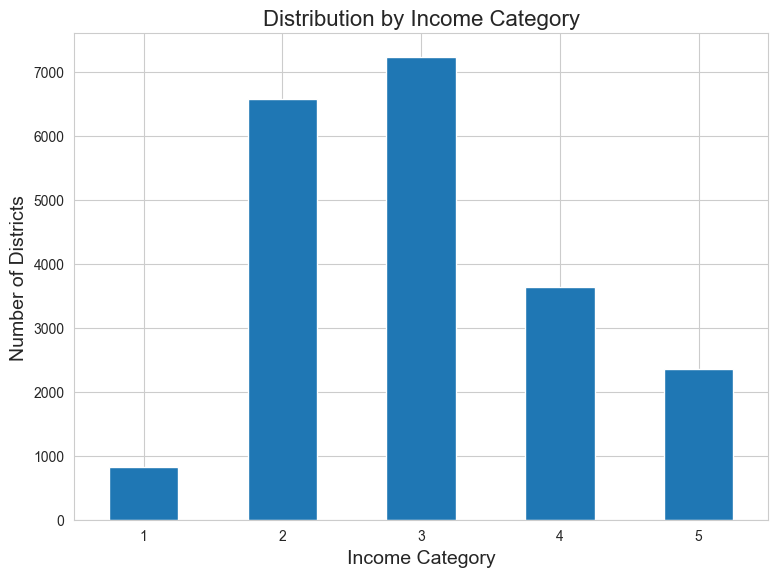

In [62]:
# Bar plot for income_cat
fig, ax = plt.subplots(figsize=(8, 6))

housing_full["income_cat"].value_counts().sort_index().plot.bar(
    ax=ax,
    rot=0,
    grid=True
)

# Aesthetic adjustments
ax.set_title("Distribution by Income Category", fontsize=16)
ax.set_xlabel("Income Category")
ax.set_ylabel("Number of Districts")

plt.tight_layout()
plt.show()

In [63]:
#stratified split
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing_full, test_size=0.2, stratify=housing_full["income_cat"],
    random_state=42)

In [64]:


# Create comparison table using predefined bins and labels
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({ "Overall %": income_cat_proportions(housing_full),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [65]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

# Discover and Visualize Data

In [66]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all the districts to visualize the data.

"The following scatter plot displays the geographical distribution of housing in California. High-density areas are clearly visible, as well as variations in median house values based on location."

<Axes: xlabel='longitude', ylabel='latitude'>

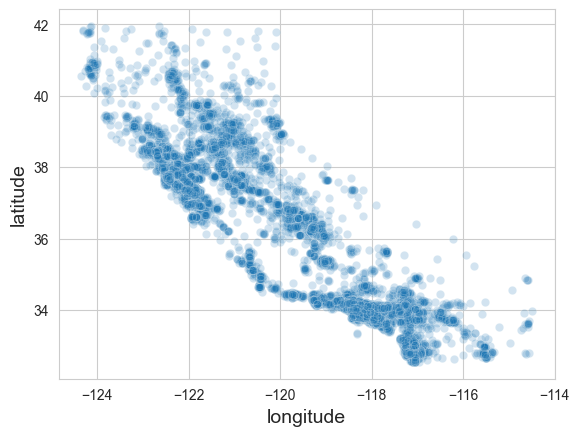

In [71]:
sns.scatterplot(x='longitude', y='latitude', data=housing, alpha=0.2)

The scatter plot uses circle size to represent district population and color to indicate median house value, applying the 'turbo' colormap to highlight price variations from low (blue) to high (red).

The image indicates a strong relationship between housing prices, location, and population density. Although ocean proximity can be a relevant factor, its influence is not consistent across all regions.

<Figure size 1200x800 with 0 Axes>

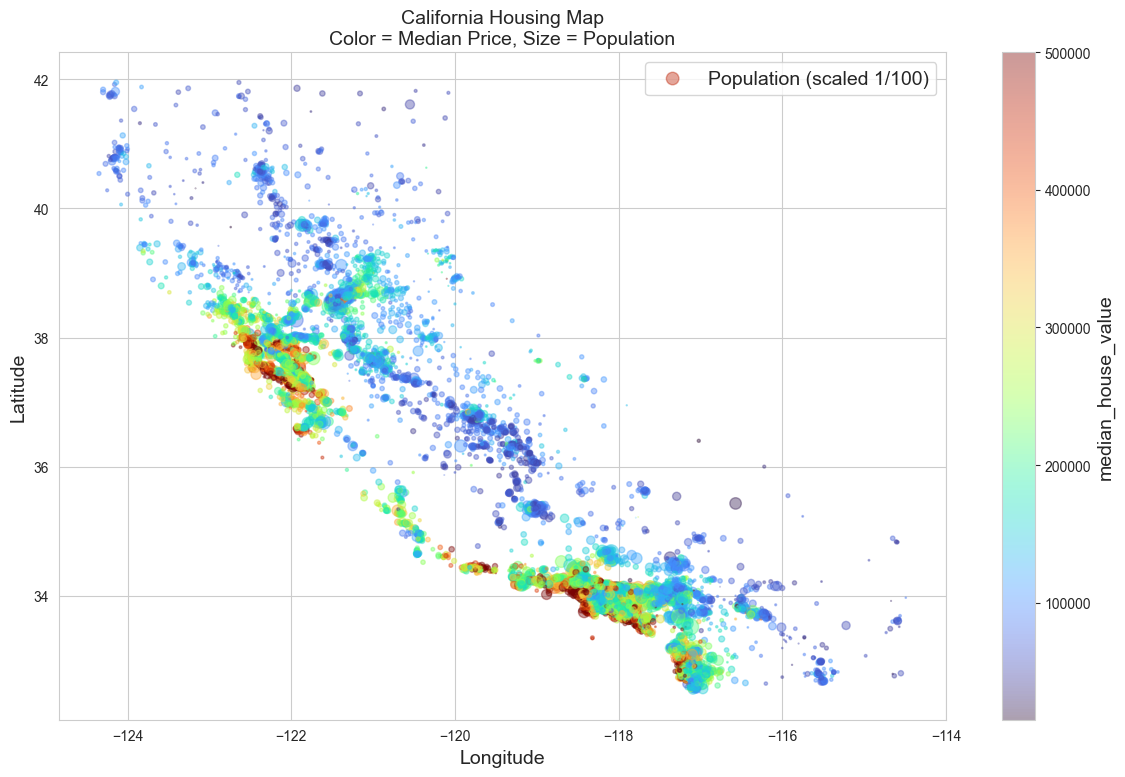

In [78]:
import matplotlib.pyplot as plt

cmap = plt.colormaps['turbo']  # Modern alternative to plt.cm.get_cmap()

plt.figure(figsize=(12, 8))
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population'] / 100,
    label='Population (scaled 1/100)',
    c='median_house_value',
    cmap=cmap,
    colorbar=True,
    figsize=(12, 8)
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing Map\nColor = Median Price, Size = Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Looking for Correlations